# Hopkins Statistic for Cluster Tendency

https://www.r-bloggers.com/assessing-clustering-tendency-a-vital-issue-unsupervised-machine-learning/

Paper: https://ieeexplore.ieee.org/document/1375706
        
Python Implementation: https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/

Assess if non-random structure exists in the data by measuring the probability that the data is generated by a uniform data distribution.

Algorithm
Let $D$ be a dataset. The Hopkins statistic can be calculated as follow:

1. Sample uniformly $n$ points $(p_1,...,p_n)$ from $D$.
2. For each point $p_i \in D$, find it’s nearest neighbor $p_j$; then compute the distance between $p_i$ and $p_j$ and denote it as $x_i=dist(p_i,p_j)$
3. Generate a simulated dataset $(random_D)$ drawn from a random uniform distribution with $n$ points $(q_1,... , q_n)$ and the same variation as the original real dataset $D$.
4. For each point $q_i \in random_D$, find it’s nearest neighbor $qj$ in $D$; then compute the distance between $q_i$ and $q_j$ and denote it $y_i = dist(q_i, q_j)$
5. Calculate the **Hopkins statistic** $(H)$ as the mean nearest neighbor distance in the random dataset divided by the sum of the mean nearest neighbor distances in the real and across the simulated dataset.

The formula is defined as follow:

$H = \frac{\sum\limits_{i=1}^ny_i}{\sum\limits_{i=1}^nx_i + \sum\limits_{i=1}^ny_i}$

A value of H about 0.5 means that sum\limits_{i=1}^ny_i and sum\limits_{i=1}^nx_i are close to each other, and thus the data D is uniformly distributed.

The null and the alternative hypotheses are defined as follow:

* _Null hypothesis_: the dataset D is uniformly distributed (i.e., no meaningful clusters)
* _Alternative hypothesis_: the dataset D is not uniformly distributed (i.e., contains meaningful clusters)

If the value of Hopkins statistic is close to zero, then we can reject the _null hypothesis_ and conclude that the dataset D is significantly a clusterable data.

In [1]:
!pip install pydataset

In [2]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0
 
    return 1-H

/home/jbslanka/mypython/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


0.19089476038349507

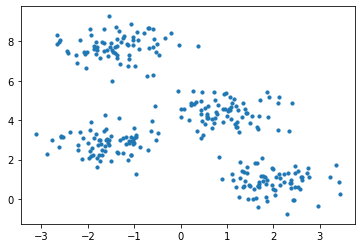

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Generate blobs
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=10);
hopkins(X)

0.4117844912584233

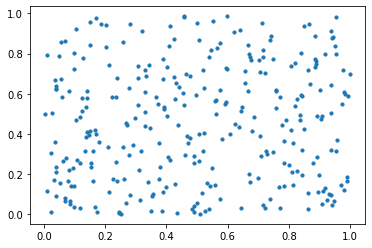

In [4]:
X_rand = np.random.rand(300,2)
plt.scatter(X_rand[:, 0], X_rand[:, 1], s=10)
hopkins(X_rand)

0.5943485363827214

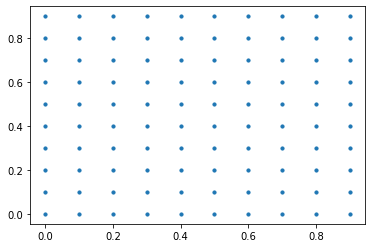

In [5]:
X_uniform = np.zeros((100,2))
for x in range(0,10):
    for y in range(0,10):
        X_uniform[x*10+y][0] = x/10
        X_uniform[x*10+y][1] = y/10
        
plt.scatter(X_uniform[:, 0], X_uniform[:, 1], s=10)
hopkins(X_uniform)        

## Some code on Old Faithful ...

Left some my mistakes in place as an example


In [6]:
from pydataset import data
faithful_df = data("faithful")
#Waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA.
faithful_df.describe()

,eruptions,waiting
count,272.000000,272.000000
mean,3.487783,70.897059
std,1.141371,13.594974
min,1.600000,43.000000
25%,2.162750,58.000000
50%,4.000000,76.000000
75%,4.454250,82.000000
max,5.100000,96.000000


Number of iterations:  3
Hopkins Statistic:  0.13790482363212686


Text(0.5, 1.0, 'Old Faithful')

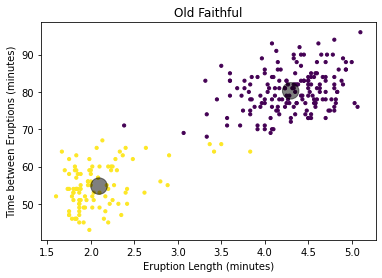

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(faithful_df)
y_kmeans = kmeans.predict(faithful_df)

print ("Number of iterations: ", kmeans.n_iter_)
print ("Hopkins Statistic: ", hopkins(faithful_df.values))

centers = kmeans.cluster_centers_

plt.scatter(faithful_df.eruptions, faithful_df.waiting, c=y_kmeans, s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=faithful_df.count(), alpha=0.5);
plt.xlabel("Eruption Length (minutes)")
plt.ylabel("Time between Eruptions (minutes)")
plt.title("Old Faithful")
 

Clusters look a bit odd...   Different magnitudes between the x and y coordinates are causing issues - need to scale both down between 0 and 1.

Number of iterations:  2
Hopkins Statistic:  0.12273080439291484


Text(0.5, 1.0, 'Old Faithful')

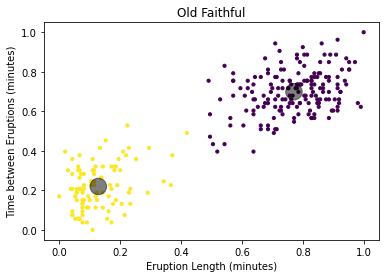

In [8]:
from sklearn import preprocessing
f_values = faithful_df.values
min_max_scaler = preprocessing.MinMaxScaler()
f_scaled = min_max_scaler.fit_transform(f_values)

kmeans = KMeans(n_clusters=2)
kmeans.fit(f_scaled)
y_kmeans = kmeans.predict(f_scaled)

print ("Number of iterations: ", kmeans.n_iter_)
print ("Hopkins Statistic: ", hopkins(faithful_df.values))

centers = kmeans.cluster_centers_

plt.scatter(f_scaled[:, 0], f_scaled[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=faithful_df.count(), alpha=0.5);
plt.xlabel("Eruption Length (minutes)")
plt.ylabel("Time between Eruptions (minutes)")
plt.title("Old Faithful")

graph looks "correct", but the x and y labels are off..  

Plot the original data, and then put the centers into place

Text(0.5, 1.0, 'Old Faithful')

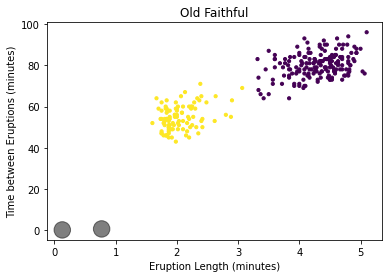

In [9]:
plt.scatter(faithful_df.eruptions, faithful_df.waiting, c=y_kmeans, s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=faithful_df.count(), alpha=0.5);
plt.xlabel("Eruption Length (minutes)")
plt.ylabel("Time between Eruptions (minutes)")
plt.title("Old Faithful")

Sigh....  need to transform the computed centers back tot the original scale.  use "inverse_transform"

Text(0.5, 1.0, 'Old Faithful')

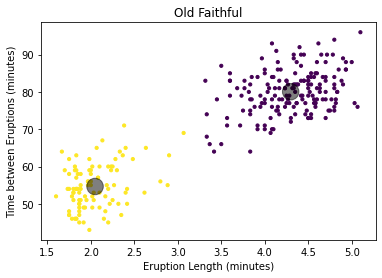

In [10]:
centers_transformed =  min_max_scaler.inverse_transform(centers)
plt.scatter(faithful_df.eruptions, faithful_df.waiting, c=y_kmeans, s=10, cmap='viridis')
plt.scatter(centers_transformed[:, 0], centers_transformed[:, 1], c='black', s=faithful_df.count(), alpha=0.5);
plt.xlabel("Eruption Length (minutes)")
plt.ylabel("Time between Eruptions (minutes)")
plt.title("Old Faithful")

## Elbow Method
Compute the sum of squared distances of the samples to their closest cluster center - within cluster sum of squares (WCSS)

from sklearn.metrics import silhouette_samples, silhouette_scoreFind the point of diminishing  returns

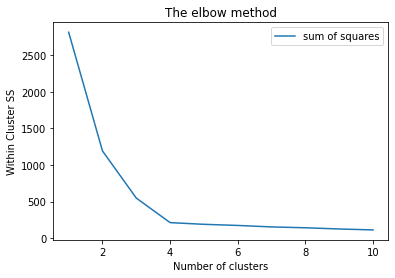

In [11]:
ssd = []
kMin = 1
kMax = 10 
for i in range(kMin, kMax+1):  # try 300 to demonstrate the WCCS going to zero, just be prepared to wait
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(kMin, kMax+1), ssd, label="sum of squares")
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster SS')
plt.legend()
plt.show()

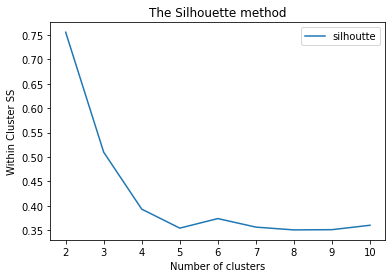

In [12]:
from sklearn.metrics import  silhouette_score

sh  = []
kMin = 2
kMax = 10 
for i in range(kMin, kMax+1):  # try 300 to demonstrate the WCCS going to zero, just be prepared to wait
    kmeans = KMeans(n_clusters = i)
    fs_centers = kmeans.fit_predict(f_scaled)
    sh.append(silhouette_score(f_scaled,fs_centers))

    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(kMin, kMax+1), sh, label="silhoutte")
plt.title('The Silhouette method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster SS')
plt.legend()
plt.show()